In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('../input/delhids/Dataset.csv')
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%Y')
df.set_index('Date',inplace=True)
df.head()

,dayofweek,tempmax,tempmin,temp,feelslike,cloudcover,dew,humidity,solarenergy,sunrise,sunset,Max Demand Met (MW),Energy Met (MU)
Date,,,,,,,,,,,,,
2022-01-01,5,19.5,6.3,11.9,11.9,9.7,8.3,80.7,14.3,2022-01-01T07:14:02,2022-01-01T17:35:18,4470,70.5
2022-01-02,6,19.7,7.5,12.7,12.7,15.4,9.0,80.9,13.7,2022-01-02T07:14:16,2022-01-02T17:36:00,4034,66.3
2022-01-03,0,20.6,7.5,13.8,13.8,26.3,9.0,76.1,14.3,2022-01-03T07:14:30,2022-01-03T17:36:43,4467,71.8
2022-01-04,1,22.5,9.8,15.8,15.8,73.8,9.2,71.1,13.0,2022-01-04T07:14:42,2022-01-04T17:37:27,4441,70.0
2022-01-05,2,15.0,12.2,13.7,13.7,96.1,12.3,91.8,2.1,2022-01-05T07:14:52,2022-01-05T17:38:11,4322,73.4


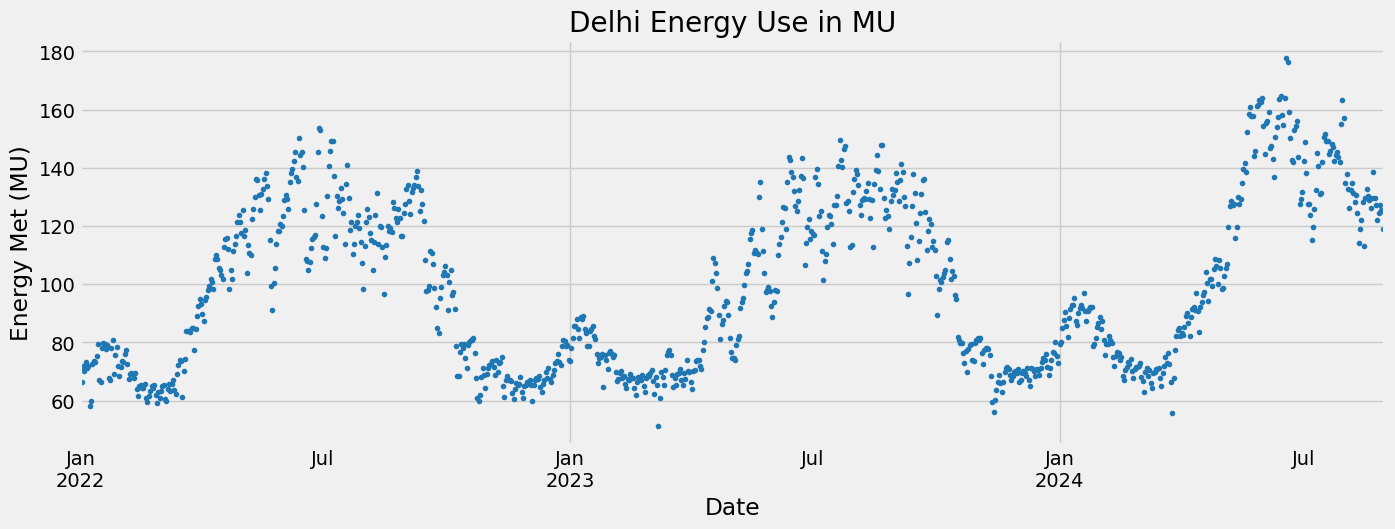

In [3]:
df['Energy Met (MU)'].plot(style='.',
                      figsize=(15,5),
                      color=color_pal[0],
                      title='Delhi Energy Use in MU')
plt.xlabel('Date')
plt.ylabel('Energy Met (MU)')
plt.show()

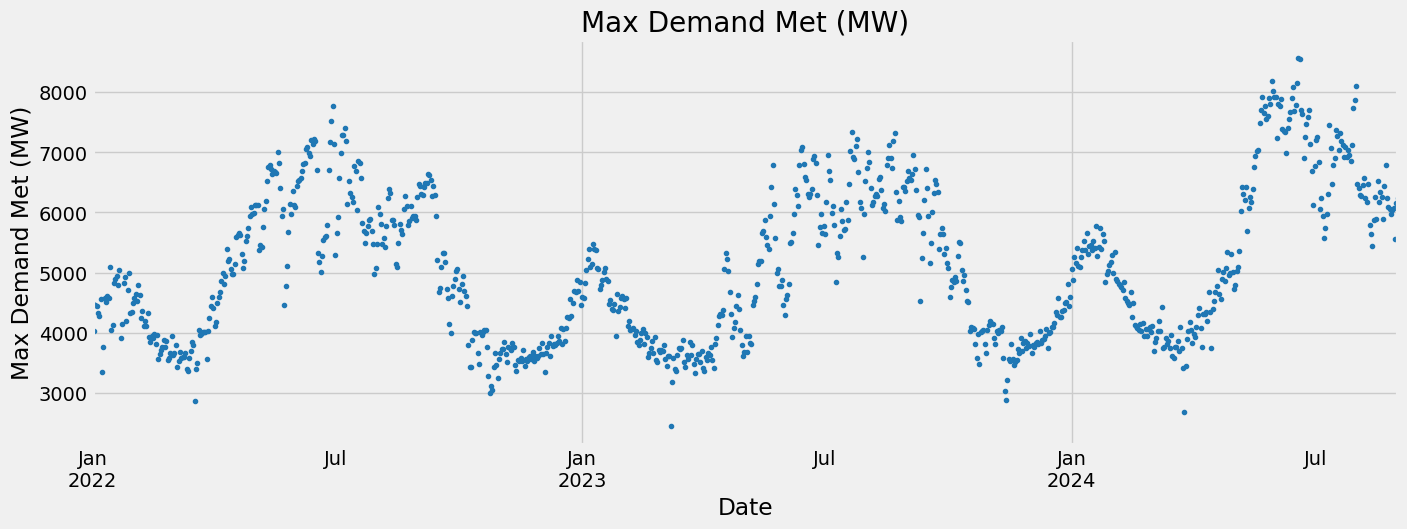

In [4]:
df['Max Demand Met (MW)'].plot(style='.',
                      figsize=(15,5),
                      color=color_pal[0],
                      title='Max Demand Met (MW)')
plt.xlabel('Date')
plt.ylabel('Max Demand Met (MW)')
plt.show()

# Train/Test Split

<Axes: title={'center': 'Data Train/Test Split'}, xlabel='Date'>

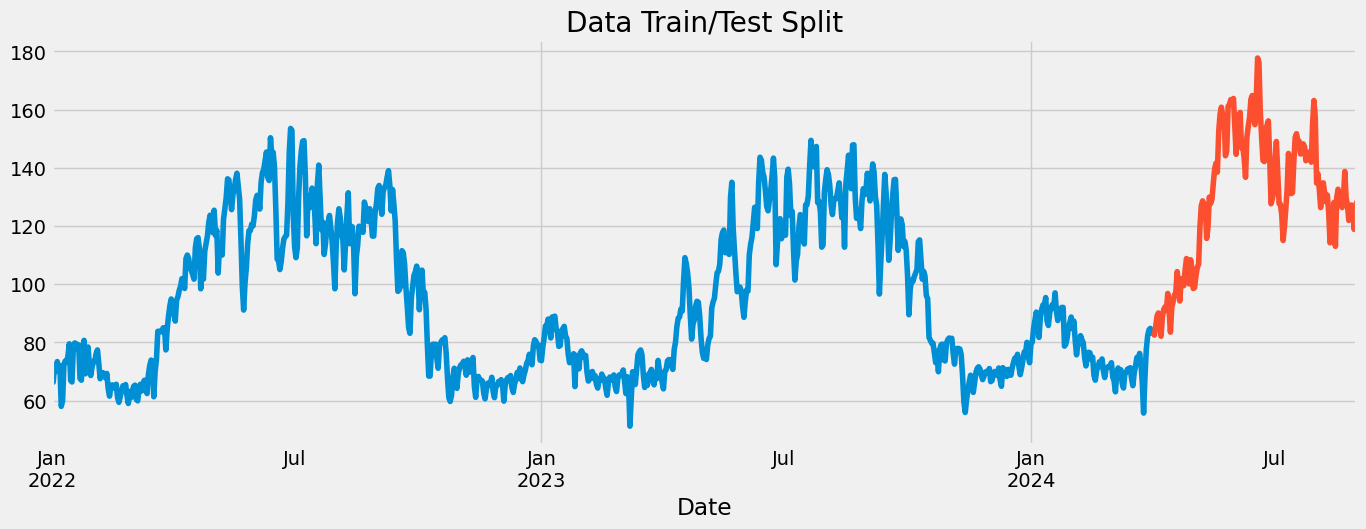

In [5]:
train = df.loc[df.index < '04-01-2024']
test = df.loc[df.index >= '04-01-2024']

fig, ax = plt.subplots(figsize=(15,5))
train['Energy Met (MU)'].plot(ax=ax, label='Train',title='Data Train/Test Split')
test['Energy Met (MU)'].plot(ax=ax, label='Test')


<Axes: xlabel='Date'>

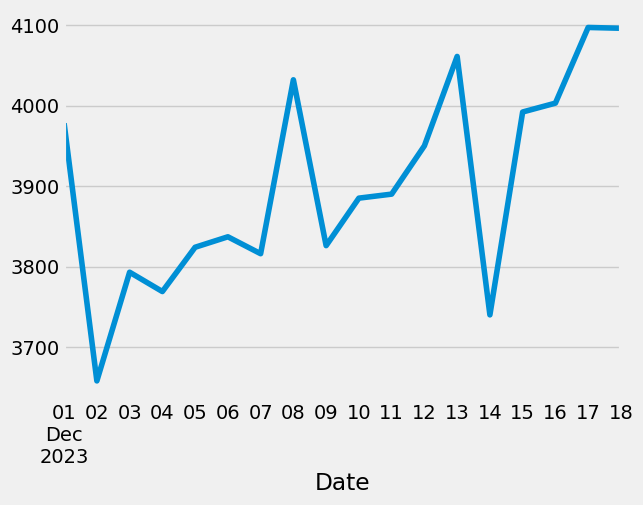

In [6]:
df['Max Demand Met (MW)'].loc[(df.index >= '12-01-2023')  & (df.index <= '12-18-2023')].plot()

In [7]:
def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize F/T Relationship

<Axes: xlabel='month', ylabel='Max Demand Met (MW)'>

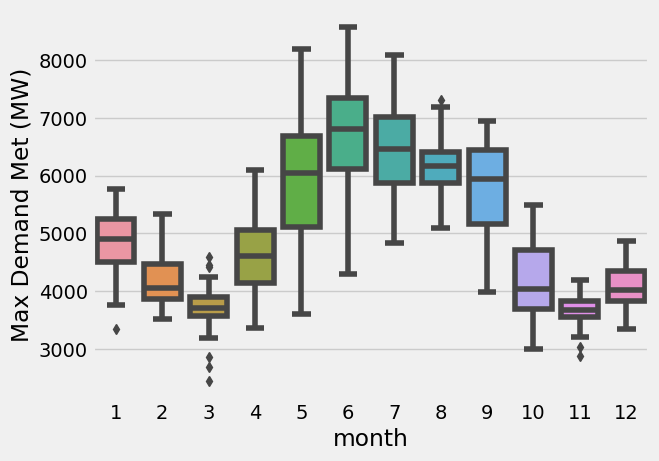

In [8]:
sns.boxplot(data=df,x='month',y = 'Max Demand Met (MW)')

<Axes: xlabel='month', ylabel='Energy Met (MU)'>

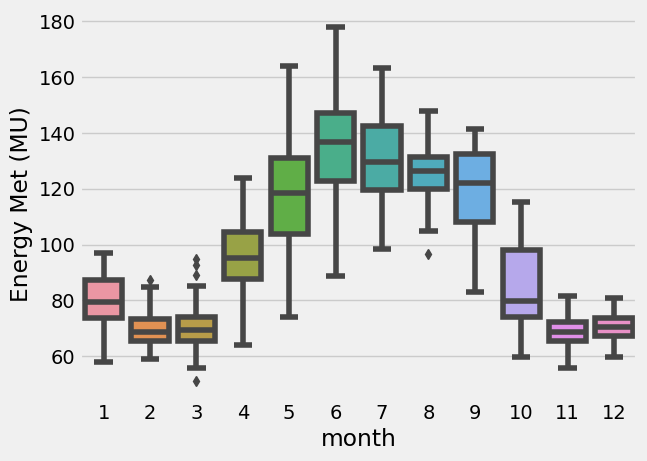

In [9]:
sns.boxplot(data=df,x='month',y = 'Energy Met (MU)')

# The Model

In [10]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'tempmax', 'tempmin', 'temp', 'feelslike', 'cloudcover','dew','humidity','solarenergy','quarter','month','year','dayofmonth','weekofyear']
TARGET = ['Max Demand Met (MW)','Energy Met (MU)']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
print(y_train['Energy Met (MU)'].isnull().sum())
print(y_test['Energy Met (MU)'].isnull().sum())


0
0


In [12]:
# Initialize models for each target
reg_maxDemand = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50, learning_rate=0.01)
reg_energyMet = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50, learning_rate=0.01)

# Fit each model with its respective target
reg_maxDemand.fit(X_train, y_train['Max Demand Met (MW)'],
                   eval_set=[(X_test, y_test['Max Demand Met (MW)'])],
                   verbose=50)

reg_energyMet.fit(X_train, y_train['Energy Met (MU)'],
                   eval_set=[(X_test, y_test['Energy Met (MU)'])],
                   verbose=50)


[0]	validation_0-rmse:1906.50260
[50]	validation_0-rmse:1376.68348
[100]	validation_0-rmse:1069.47458
[150]	validation_0-rmse:881.47228
[200]	validation_0-rmse:770.18544
[250]	validation_0-rmse:704.52675
[300]	validation_0-rmse:664.49336
[350]	validation_0-rmse:639.50996
[400]	validation_0-rmse:629.91186
[450]	validation_0-rmse:620.76843
[499]	validation_0-rmse:615.92068
[0]	validation_0-rmse:43.20179
[50]	validation_0-rmse:30.99873
[100]	validation_0-rmse:23.49888
[150]	validation_0-rmse:18.97475
[200]	validation_0-rmse:16.26935
[250]	validation_0-rmse:14.63643
[300]	validation_0-rmse:13.60540
[350]	validation_0-rmse:12.99396
[400]	validation_0-rmse:12.63613
[450]	validation_0-rmse:12.42864
[499]	validation_0-rmse:12.31268


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Factors Importance

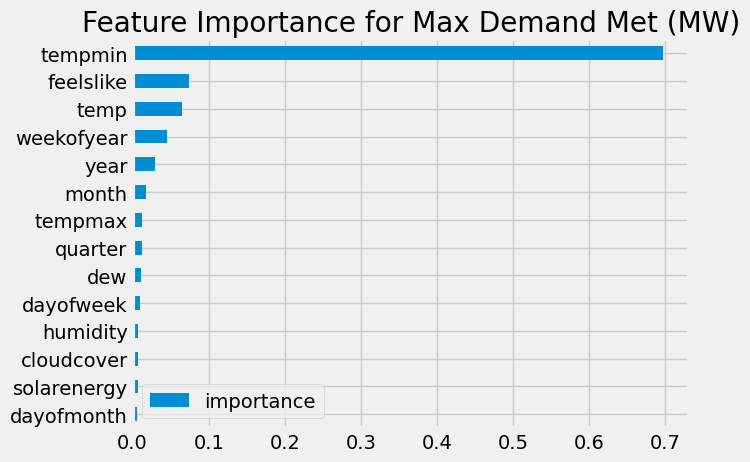

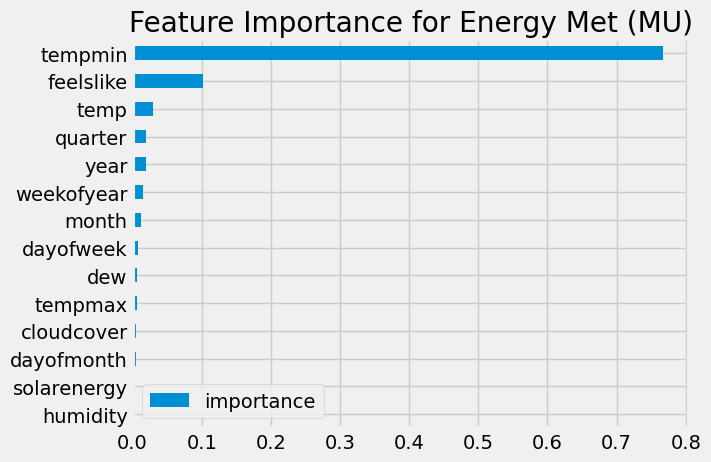

In [13]:
def plot_feature_importances(model, feature_names, title):
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=feature_names,
                      columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title=title)
    plt.show()

# Plot feature importances for each model
plot_feature_importances(reg_maxDemand, X_train.columns, 'Feature Importance for Max Demand Met (MW)')
plot_feature_importances(reg_energyMet, X_train.columns, 'Feature Importance for Energy Met (MU)')

# Forecast on Test

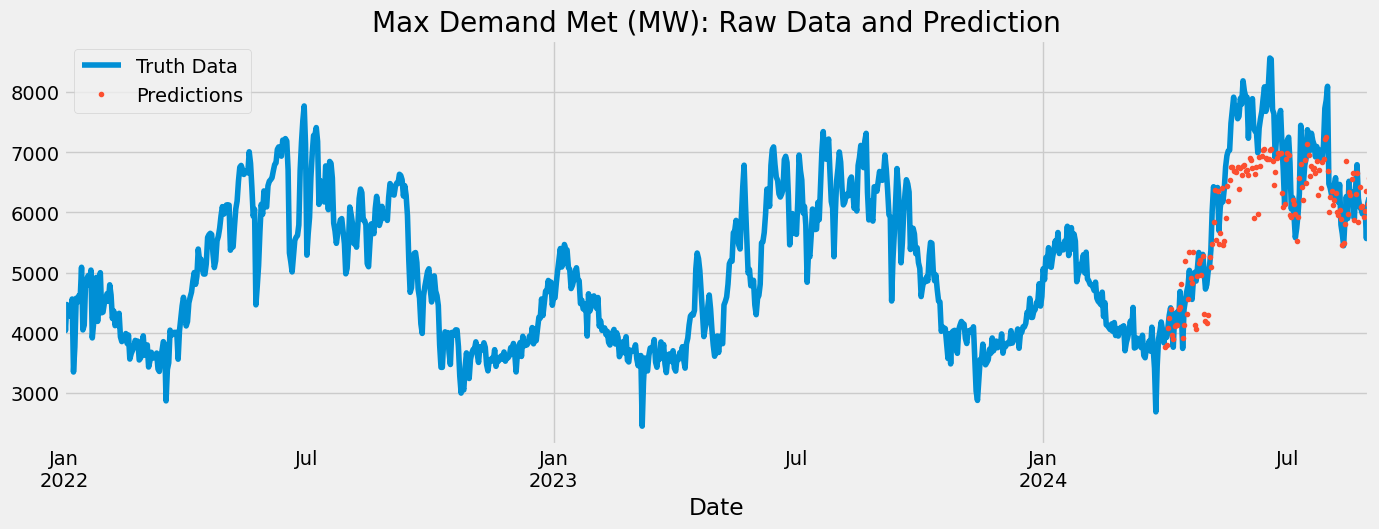

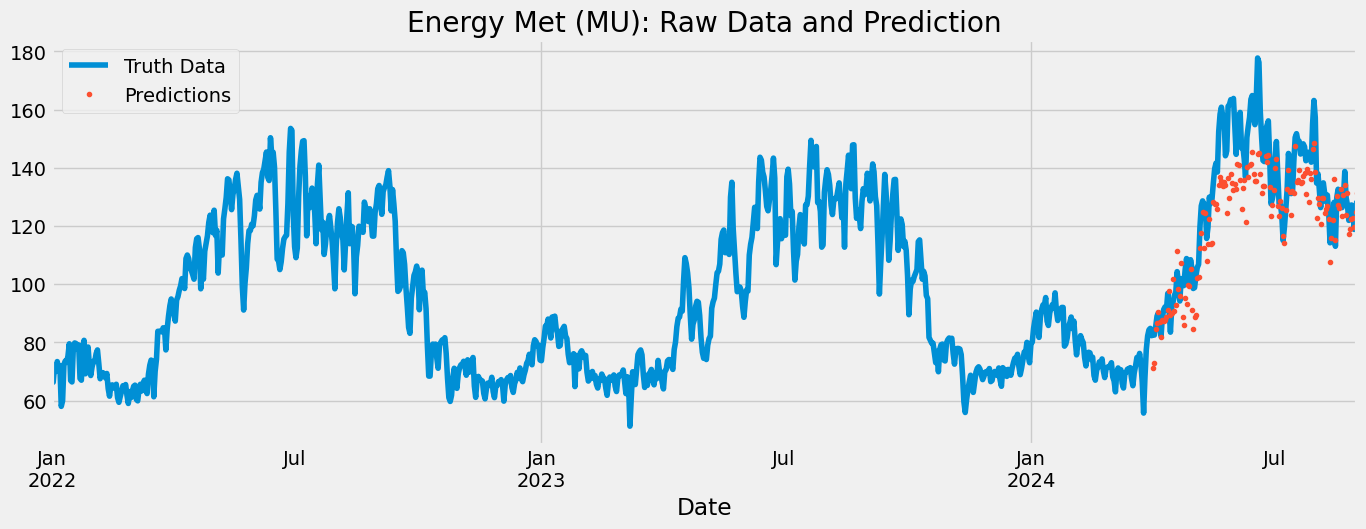

In [14]:
# Make predictions 
test['prediction_maxDemand'] = reg_maxDemand.predict(X_test)
test['prediction_energyMet'] = reg_energyMet.predict(X_test)

df = df.merge(test[['prediction_maxDemand', 'prediction_energyMet']], 
              how='left', left_index=True, right_index=True)

# for Max Demand Met (MW)
ax = df[['Max Demand Met (MW)']].plot(figsize=(15, 5))
df['prediction_maxDemand'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Max Demand Met (MW): Raw Data and Prediction')
plt.show()

# for Energy Met (MU)
ax = df[['Energy Met (MU)']].plot(figsize=(15, 5))
df['prediction_energyMet'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Energy Met (MU): Raw Data and Prediction')
plt.show()